In [12]:
import pandas as pd
pd.options.mode.copy_on_write = True
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../figures.mplstyle")

rate = 147468/2
Ngen = 10000000

n_bunches = 72 * ((3 + 3 + 4)*3 + (3 + 3 + 3))
n_missing_bunches = 3*(8*(2+2+3) + 2*38 + 39) + (8 * (2+2+2) + 38 * 2 + 119)
cycle_time = 88924 #ns
duty_factor = 25*n_bunches / cycle_time



In [3]:
data = pd.read_csv("MuonsOut.txt",delim_whitespace=" ")
data.keys()

Index(['hit1', 'hit2', 'hitboth', 't1', 't2', 'int1_x', 'int1_y', 'int1_z',
       'int2_x', 'int2_y', 'int2_z', 'theta', 'phi', 'x0', 'y0', 'z0', 'dx',
       'dy', 'dz'],
      dtype='object')

In [14]:
data_hit1 = data.query("hit1==1")
data_hit2 = data.query("hit2==1")
print("Singles rate = ",(len(data_hit1)+len(data_hit2))*rate/Ngen)
data_hitboth = data.query("hitboth==1")

Singles rate =  5630.954979


In [32]:
data_hitboth["first_plane"] = np.array(data_hitboth.t1 > data_hitboth.t2,dtype=int) + 1
for coord in ["x","y","z"]:
    data_hitboth["first_plane_%s"%coord] = np.where(data_hitboth.first_plane==1,data_hitboth["int1_%s"%coord],data_hitboth["int2_%s"%coord])
    data_hitboth["second_plane_%s"%coord] = np.where(data_hitboth.first_plane==1,data_hitboth["int2_%s"%coord],data_hitboth["int1_%s"%coord])

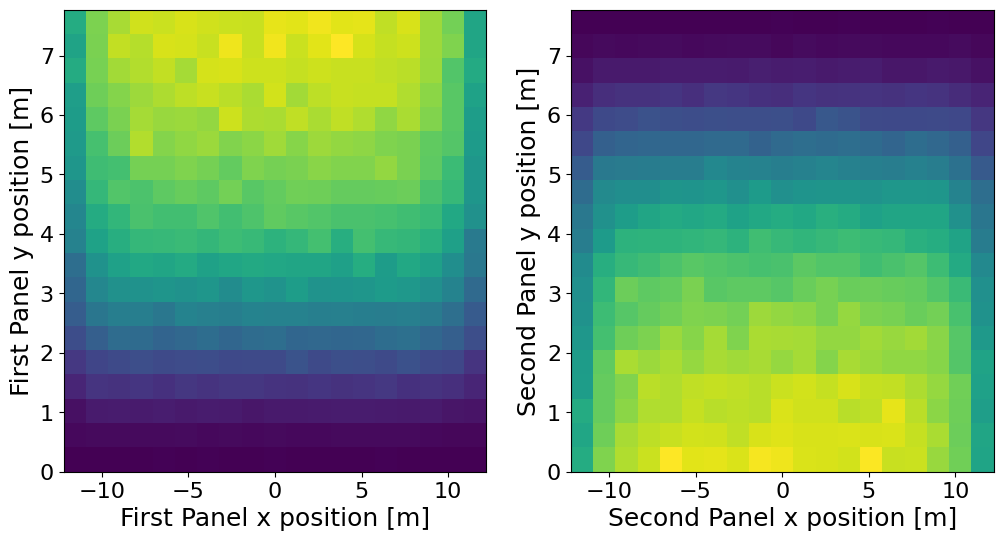

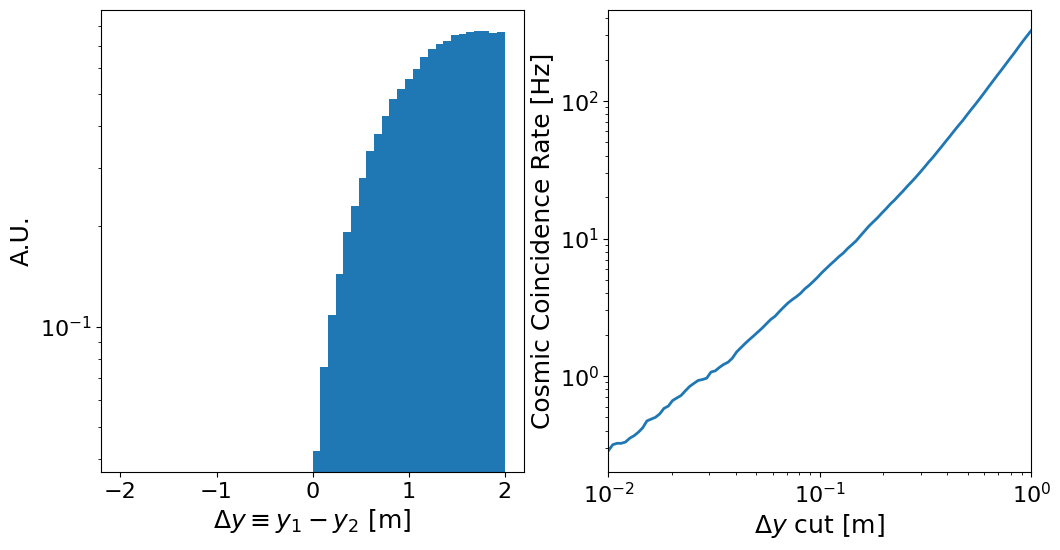

In [110]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
ybins = np.linspace(-12.2,12.2,20)
zbins = np.linspace(0,7.77,20)

ax[0].hist2d(data_hitboth["first_plane_y"],data_hitboth["first_plane_z"],bins=(ybins,zbins))
ax[1].hist2d(data_hitboth["second_plane_y"],data_hitboth["second_plane_z"],bins=(ybins,zbins))
ax[0].set_xlabel("First Panel x position [m]")
ax[0].set_ylabel("First Panel y position [m]")
ax[1].set_xlabel("Second Panel x position [m]")
ax[1].set_ylabel("Second Panel y position [m]")
plt.show()

fig,ax = plt.subplots(1,2,figsize=(12,6))

data_hitboth["muon_height_difference"] = data_hitboth.first_plane_z - data_hitboth.second_plane_z
ax[0].hist(data_hitboth.muon_height_difference,bins=np.linspace(-2,2,51),density=True)
vertical_resolution_array = np.logspace(-2,0,100)
bkg_rate = np.empty_like(vertical_resolution_array)
for i,vertical_resolution in enumerate(vertical_resolution_array):
    num_bkg = sum(data_hitboth.muon_height_difference <= vertical_resolution)
    bkg_rate[i] = rate*num_bkg/Ngen
ax[1].plot(vertical_resolution_array,bkg_rate)
ax[1].set_xlim(vertical_resolution_array[0],vertical_resolution_array[-1])
ax[1].loglog()
ax[0].semilogy()
ax[0].set_xlabel(r"$\Delta y \equiv y_1 - y_2$ [m]")
ax[0].set_ylabel(r"A.U.")
ax[1].set_xlabel(r"$\Delta y$ cut [m]")
ax[1].set_ylabel(r"Cosmic Coincidence Rate [Hz]")
plt.show()

# what about for nu-induced muons?

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 8.37242301e+04, 5.40403738e+05, 9.859758

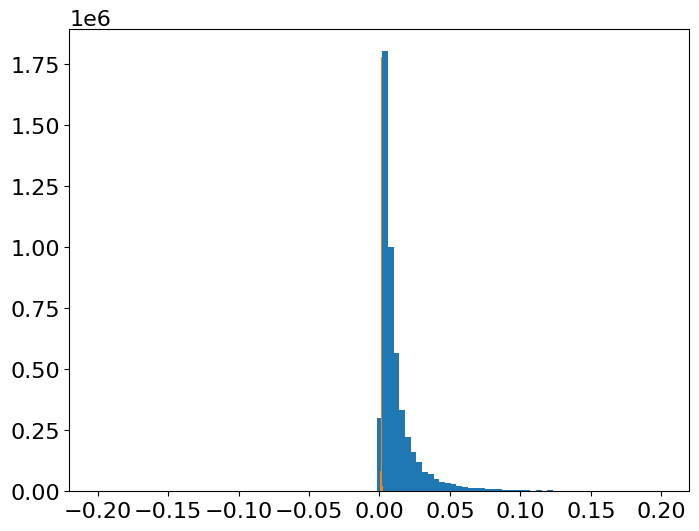

In [86]:
import awkward as ak
siren_data = pd.read_parquet("../Data/SIREN/Output/LHCb_LHC13_EPOSLHC_light_14.parquet")
siren_data_ak = ak.from_parquet("../Data/SIREN/Output/LHCb_LHC13_EPOSLHC_light_14.parquet")
mu_vertex = np.squeeze(siren_data_ak.vertex)
muon_momenta = np.array(np.squeeze(siren_data_ak.secondary_momenta[:,:,0]))
muon_momentum = np.array(np.linalg.norm(muon_momenta[:,1:],axis=1))
mu_dir = muon_momenta[:,1:] / np.expand_dims(muon_momentum,-1)
nu_momenta = np.array(np.squeeze(siren_data_ak.primary_momentum[:,0]))
nu_momentum = np.array(np.linalg.norm(nu_momenta[:,1:],axis=1))
nu_dir = nu_momenta[:,1:] / np.expand_dims(nu_momentum,-1)
plt.hist(mu_dir[:,1],bins=np.linspace(-0.2,0.2,100),weights=siren_data_ak.weights)
plt.hist(nu_dir[:,1],bins=np.linspace(-0.01,0.01,100),weights=siren_data_ak.weights)

In [89]:
first_panel_x = []
first_panel_y = []
second_panel_x = []
second_panel_y = []
weights = []
for panel in [1,2,3]:
    int_locations = np.squeeze(siren_data.query("panel%d_hit_mask_muon_survival==1"%panel)["panel%d_int_locations"%panel])
    wgts = np.squeeze(siren_data.query("panel%d_hit_mask_muon_survival==1"%panel)["weights"])
    for w,loc in zip(wgts,int_locations):
        first_panel_x.append(loc[0][0])
        first_panel_y.append(loc[0][1])
        second_panel_x.append(loc[1][0])
        second_panel_y.append(loc[1][1])
        weights.append(w)
    
    

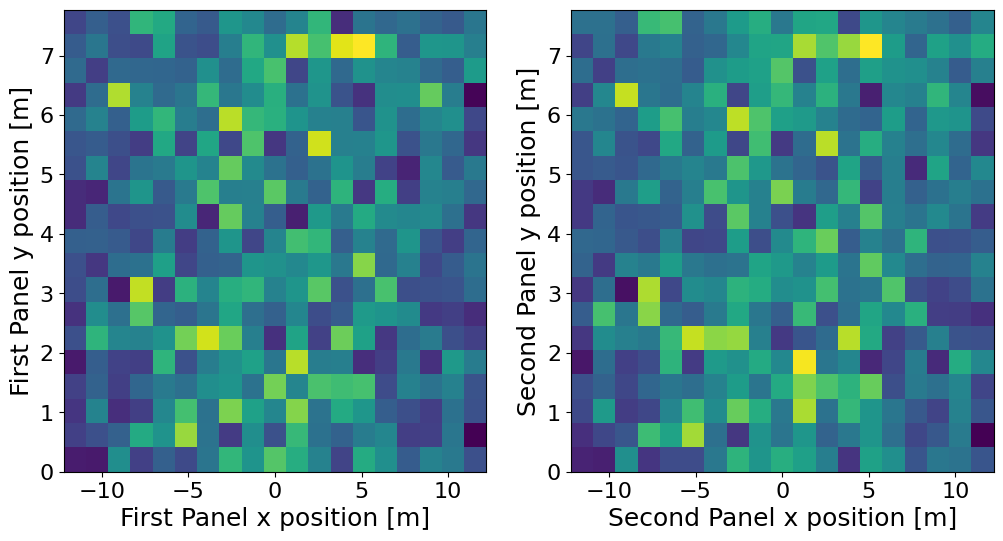

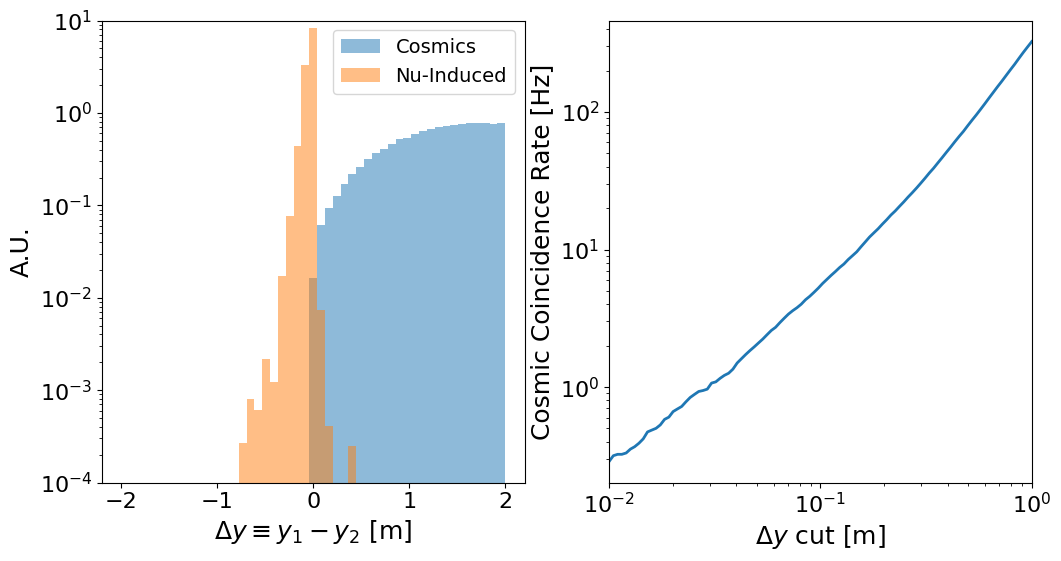

In [104]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
xbins = np.linspace(-12.2,12.2,20)
ybins = np.linspace(0,7.77,20)

ax[0].hist2d(first_panel_x,first_panel_y,bins=(xbins,ybins),weights=weights)
ax[1].hist2d(second_panel_x,second_panel_y,bins=(xbins,ybins),weights=weights)
ax[0].set_xlabel("First Panel x position [m]")
ax[0].set_ylabel("First Panel y position [m]")
ax[1].set_xlabel("Second Panel x position [m]")
ax[1].set_ylabel("Second Panel y position [m]")
plt.show()

fig,ax = plt.subplots(1,2,figsize=(12,6))

ax[0].hist(data_hitboth.muon_height_difference,bins=np.linspace(-2,2,50),density=True,alpha=0.5,label="Cosmics")
ax[0].hist(muon_height_difference,bins=np.linspace(-2,2,50),weights=weights,density=True,alpha=0.5,label="Nu-Induced")
vertical_resolution_array = np.logspace(-2,0,100)
bkg_rate = np.empty_like(vertical_resolution_array)
for i,vertical_resolution in enumerate(vertical_resolution_array):
    num_bkg = sum(data_hitboth.muon_height_difference <= vertical_resolution)
    bkg_rate[i] = rate*num_bkg/Ngen
ax[1].plot(vertical_resolution_array,bkg_rate)
ax[1].set_xlim(vertical_resolution_array[0],vertical_resolution_array[-1])
ax[0].set_ylim(1e-4,1e1)
ax[0].semilogy()
ax[0].legend()
ax[1].loglog()


ax[0].set_xlabel(r"$\Delta y \equiv y_1 - y_2$ [m]")
ax[0].set_ylabel(r"A.U.")
ax[1].set_xlabel(r"$\Delta y$ cut [m]")
ax[1].set_ylabel(r"Cosmic Coincidence Rate [Hz]")
plt.show()